In [1]:
! pip install heic2png


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\SANYAM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import warnings
from heic2png import HEIC2PNG
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix


import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
2.10.0


# Loading Dataset

In [3]:
dataset = {
             "train_data" : "../Crop Samples/",
          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            file_path = os.path.join(folderpath, file)
            if file.endswith('.HEIC'):
                heic_img = HEIC2PNG(file_path)
                heic_img.save()
                os.remove(file_path)
            data["imgpath"].append(file_path)
            data["labels"].append(folder)
        
    all_data.append(data.copy())
    data.clear()
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))

# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])

# Traing Data images count per class

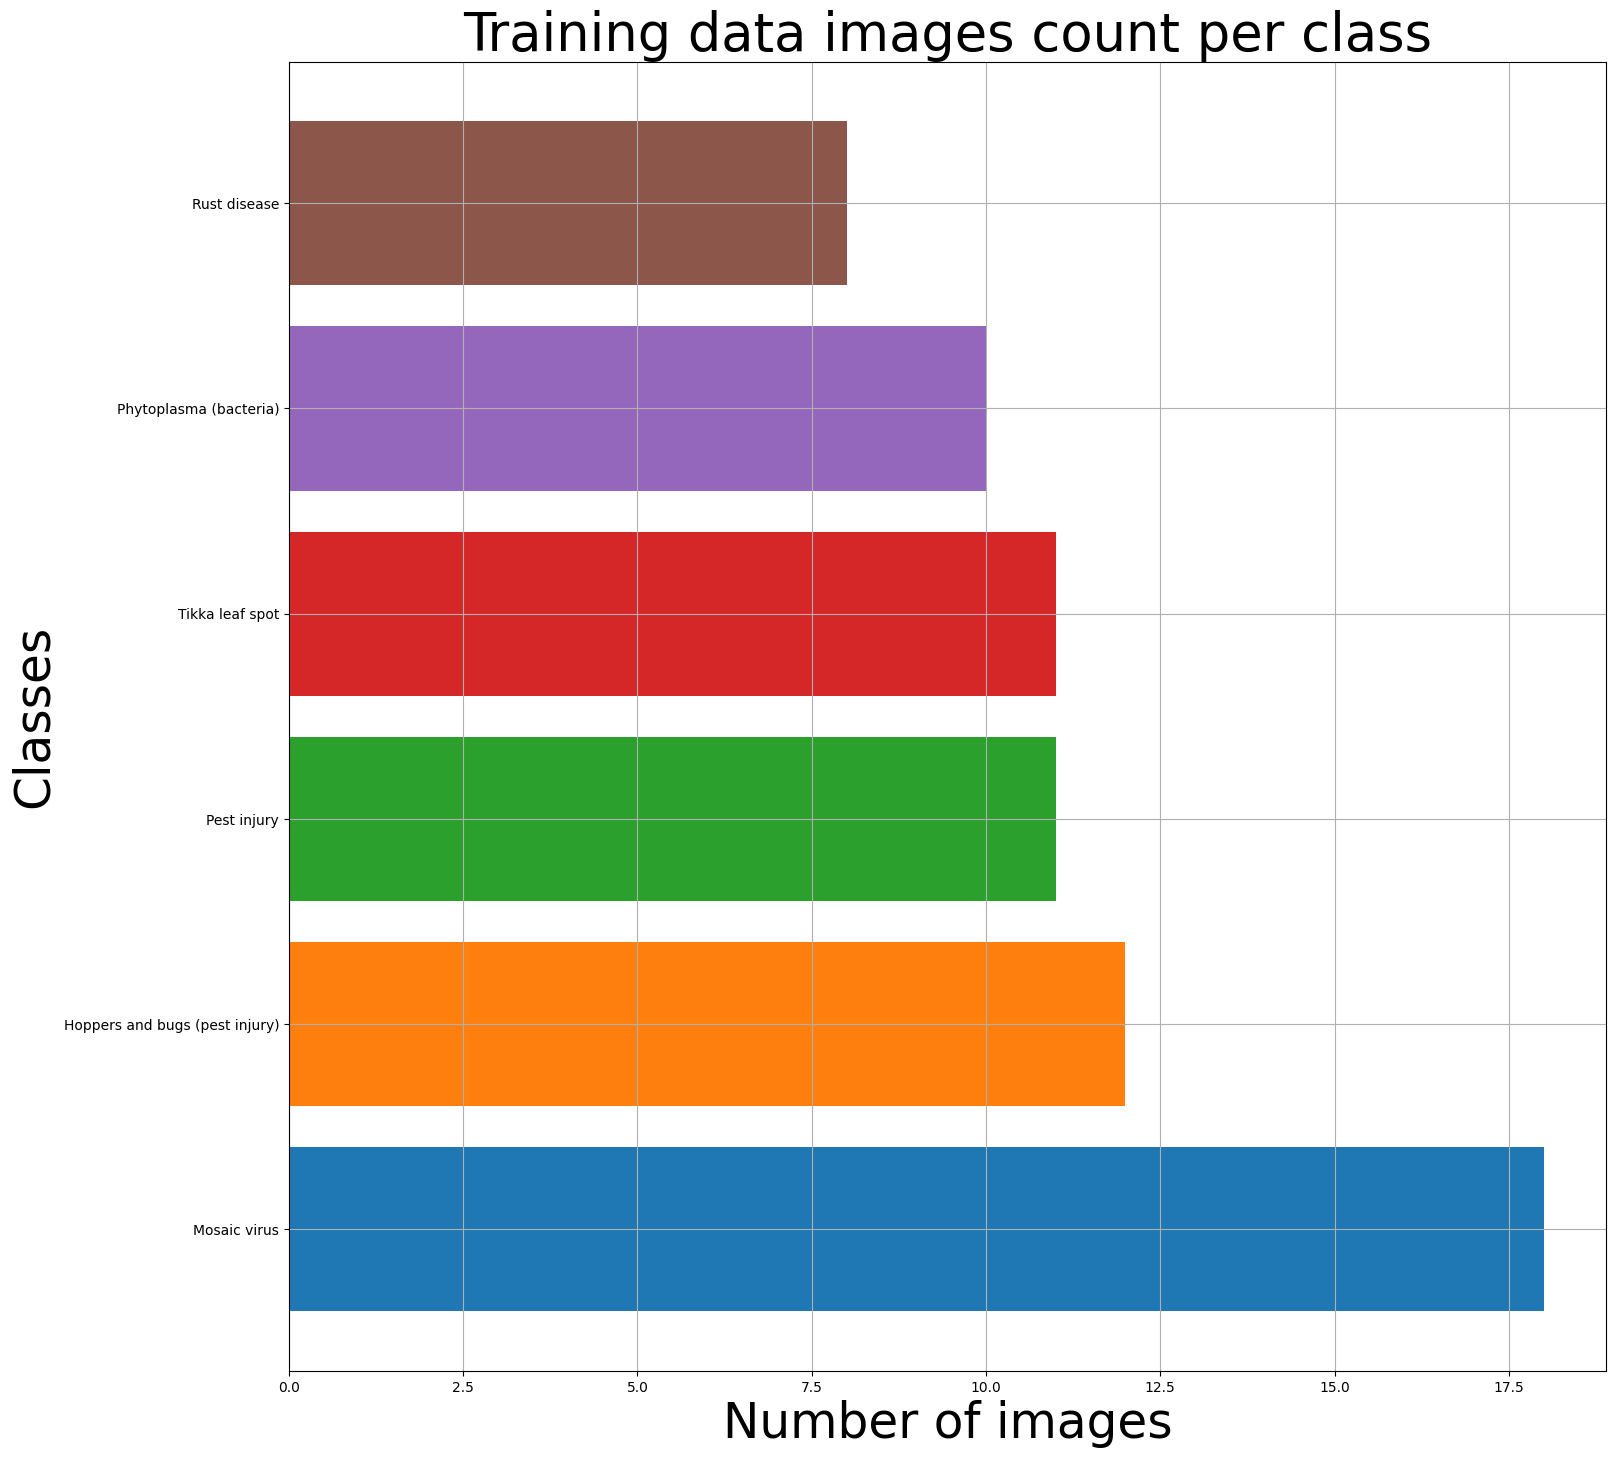

In [4]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [5]:
index

['Mosaic virus',
 'Hoppers and bugs (pest injury)',
 'Pest injury',
 'Tikka leaf spot',
 'Phytoplasma (bacteria)',
 'Rust disease']

In [6]:
train_df.sample(n=15, random_state=1)

,imgpath,labels,encoded_labels
65,../Crop Samples/Tikka leaf spot\IMG_2117.png,Tikka leaf spot,5
26,../Crop Samples/Mosaic virus\IMG_2161.png,Mosaic virus,1
66,../Crop Samples/Tikka leaf spot\IMG_2118.png,Tikka leaf spot,5
54,../Crop Samples/Rust disease\IMG_2105.png,Rust disease,4
27,../Crop Samples/Mosaic virus\IMG_2162.png,Mosaic virus,1
60,../Crop Samples/Tikka leaf spot\IMG_2111.png,Tikka leaf spot,5
49,../Crop Samples/Phytoplasma (bacteria)\IMG_213...,Phytoplasma (bacteria),3
36,../Crop Samples/Pest injury\IMG_2093.png,Pest injury,2
48,../Crop Samples/Phytoplasma (bacteria)\IMG_212...,Phytoplasma (bacteria),3
31,../Crop Samples/Pest injury\IMG_2084.png,Pest injury,2


In [7]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)

----------Train-------------
                                             imgpath  \
0  ../Crop Samples/Hoppers and bugs (pest injury)...   
1  ../Crop Samples/Hoppers and bugs (pest injury)...   
2  ../Crop Samples/Hoppers and bugs (pest injury)...   
3  ../Crop Samples/Hoppers and bugs (pest injury)...   
4  ../Crop Samples/Hoppers and bugs (pest injury)...   

                           labels  
0  Hoppers and bugs (pest injury)  
1  Hoppers and bugs (pest injury)  
2  Hoppers and bugs (pest injury)  
3  Hoppers and bugs (pest injury)  
4  Hoppers and bugs (pest injury)  
(70, 3)


In [8]:
train_df.isnull().sum()

imgpath           0
labels            0
encoded_labels    0
dtype: int64

# Creating Dataloaders

In [9]:
%%time

BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=42,
)

Found 70 validated image filenames belonging to 6 classes.
CPU times: total: 0 ns
Wall time: 9.95 ms


In [10]:
train_images.n

70

# Model Structure

In [11]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

# Training : Transfer Learning

In [12]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
], name='AugmentationLayer')


inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                               

In [13]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
2/2 [==============================] - 775s 691s/step - loss: 2.1337 - accuracy: 0.1429
Epoch 2/10
2/2 [==============================] - 959s 888s/step - loss: 2.3736 - accuracy: 0.2286
Epoch 3/10
2/2 [==============================] - 739s 61s/step - loss: 2.0129 - accuracy: 0.1286
Epoch 4/10
2/2 [==============================] - 1015s 947s/step - loss: 1.8592 - accuracy: 0.3000
Epoch 5/10
2/2 [==============================] - 4940s 72s/step - loss: 1.9866 - accuracy: 0.2429
Epoch 6/10
2/2 [==============================] - 837s 69s/step - loss: 1.7354 - accuracy: 0.3429
Epoch 7/10
2/2 [==============================] - 822s 737s/step - loss: 1.7014 - accuracy: 0.2714
Epoch 8/10
2/2 [==============================] - 767s 63s/step - loss: 1.5502 - accuracy: 0.4286
Epoch 9/10
2/2 [==============================] - 756s 63s/step - loss: 1.6871 - accuracy: 0.3429
Epoch 10/10
2/2 [==============================] - 719s 651s/step - loss: 1.8306 - accuracy: 0.2429


# Display model performance

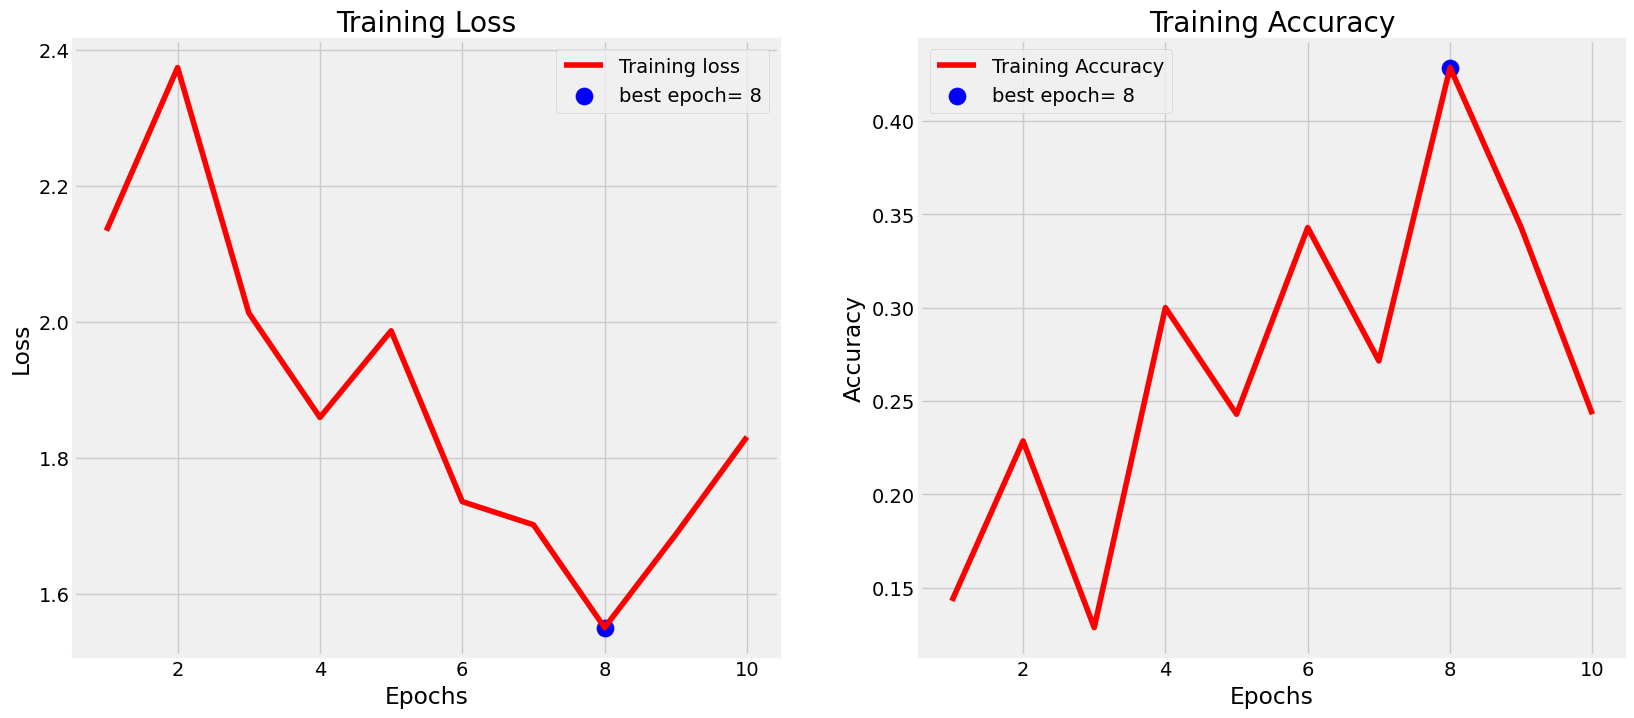

In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
index_loss = np.argmin(tr_loss)
val_lowest = tr_loss[index_loss]
index_acc = np.argmax(tr_acc)
acc_highest = tr_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [15]:
results = model.evaluate(train_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 15.58166
Test Accuracy: 11.43%


# F1 Score / Recall / Precision

In [16]:
y_true = train_images.classes
y_pred = np.argmax(model.predict(train_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=train_images.class_indices.keys()))

2/2 [==============================] - 719s 60s/step
F1 Score: 0.034188034188034185
                                precision    recall  f1-score   support

Hoppers and bugs (pest injury)       0.00      0.00      0.00        12
                  Mosaic virus       0.00      0.00      0.00        18
                   Pest injury       0.00      0.00      0.00        11
        Phytoplasma (bacteria)       0.00      0.00      0.00        10
                  Rust disease       0.11      1.00      0.21         8
               Tikka leaf spot       0.00      0.00      0.00        11

                      accuracy                           0.11        70
                     macro avg       0.02      0.17      0.03        70
                  weighted avg       0.01      0.11      0.02        70



In [17]:
from keras.models import load_model

model.save('my_model.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

# Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

55/55 [==============================] - 7s 120ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,37,Tomato___healthy,37,Tomato___healthy,/kaggle/input/new-plant-diseases-dataset/New P...,0.999986
1,1,20,Potato___Early_blight,20,Potato___Early_blight,/kaggle/input/new-plant-diseases-dataset/New P...,0.999280
2,2,6,Cherry_(including_sour)___healthy,6,Cherry_(including_sour)___healthy,/kaggle/input/new-plant-diseases-dataset/New P...,0.999751
3,3,36,Tomato___Tomato_mosaic_virus,36,Tomato___Tomato_mosaic_virus,/kaggle/input/new-plant-diseases-dataset/New P...,0.998780
4,4,12,Grape___Esca_(Black_Measles),12,Grape___Esca_(Black_Measles),/kaggle/input/new-plant-diseases-dataset/New P...,0.999963
5,5,10,Corn_(maize)___healthy,10,Corn_(maize)___healthy,/kaggle/input/new-plant-diseases-dataset/New P...,0.999991
6,6,12,Grape___Esca_(Black_Measles),12,Grape___Esca_(Black_Measles),/kaggle/input/new-plant-diseases-dataset/New P...,0.996765
7,7,16,Peach___Bacterial_spot,16,Peach___Bacterial_spot,/kaggle/input/new-plant-diseases-dataset/New P...,0.995823


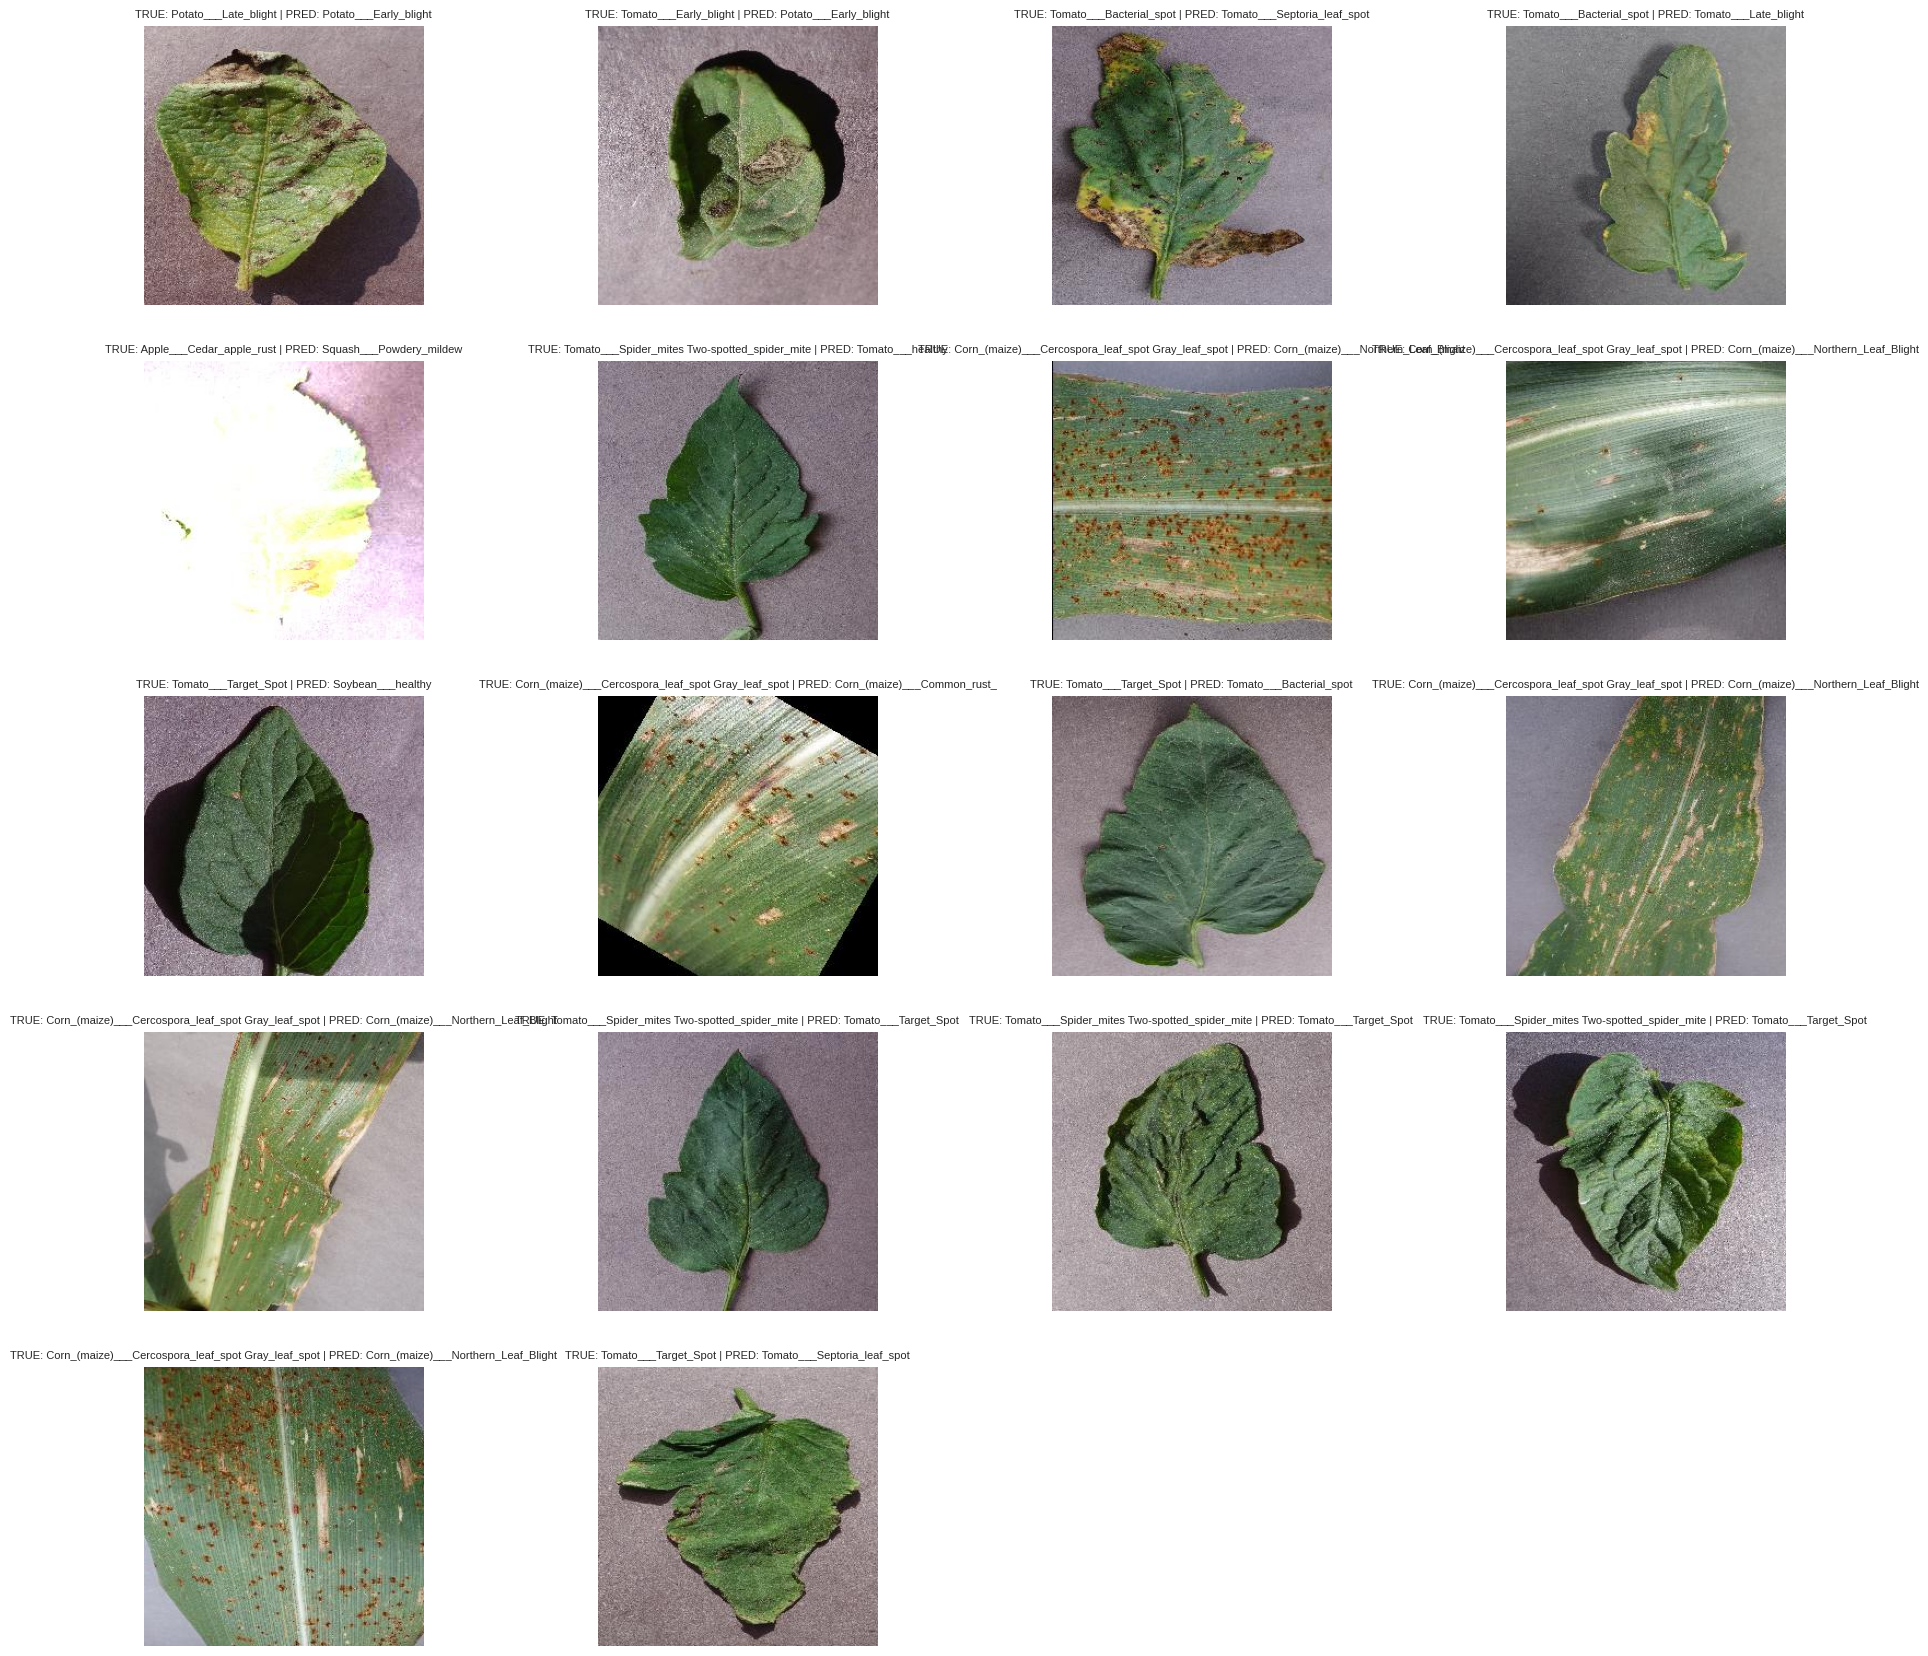

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()